<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10-FinalV1File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   DataLoaders.py  Gradcam.py    resNet.py
AlbTrainTransforms.py  displayData.py  LR_Finder.py  rohan_library.py
albumentations.py      execute.py      __pycache__


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gc
# from Gradcam import GRADCAM, PLOT
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf

REQUIRED LIBRARIES LOADED...


  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [0]:
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensor
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [8]:
dataiter = iter(trainLoader)
# iter(trainLoader).next()

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

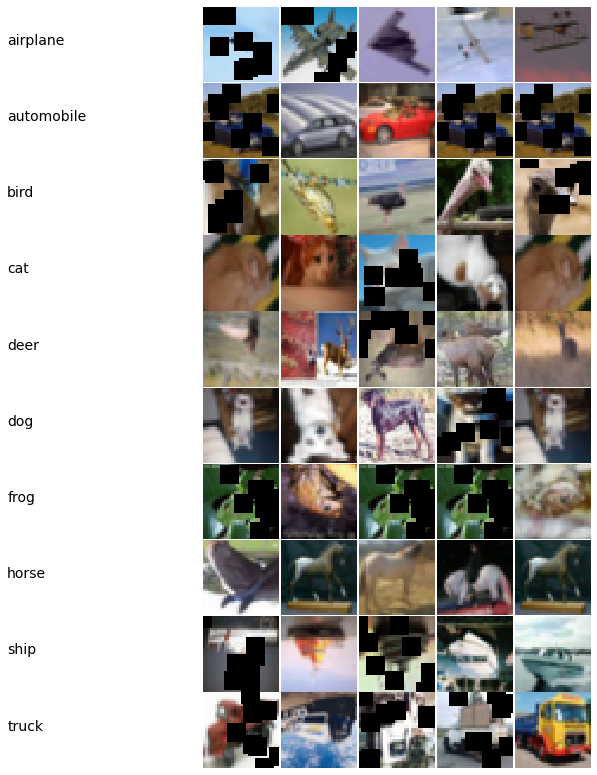

In [9]:
display.classImages(trainLoader)

**Model Summary**

In [10]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

**LR Finder**

In [0]:
torch.manual_seed(10)
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-5, weight_decay=1e-4)
model = ResNet18().to(device)


**FastAI Approach**

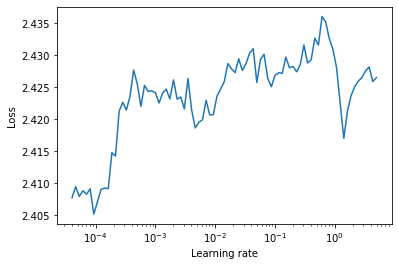

In [12]:
def fastaiApproach(model, optimizer, criterion, device ='cuda'): # fastai approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, end_lr=10, num_iter =100, step_mode='exp')
  lrF.plot()
  lrF.reset()

def lsApproach(model, optimizer, criterion, device ='cuda'): # leslie smith approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, testLoader, end_lr=10, num_iter =100, step_mode='exp')
  lrF.plot()
  lrF.reset()


fastaiApproach(model, optimizer, criterion, device)


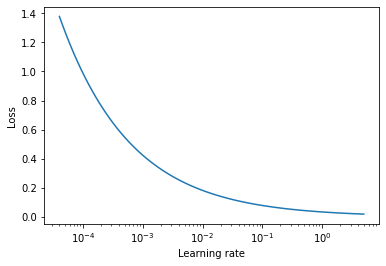

In [13]:
lsApproach(model, optimizer, criterion, device)

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self, model, device, optimizer, criterion):


    self.model = model
    self.device = device
    self.optimizer = optimizer
    self.criterion = criterion

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, trainloader, epoch, L1lambda=None):
    self.model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(self.device), target.to(self.device)
      self.optimizer.zero_grad()    # clear the gradients of all optimized variables

      # Predict
      y_pred = self.model(data)   # forward pass

      # Calculate loss
      c_loss = self.criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in self.model.parameters():
            l1_loss += torch.sum(param.abs())
          loss = c_loss +  (L1lambda * l1_loss)

      

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      self.optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm

      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_acc.append(100*correct/processed)
      # scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(loss)


  def test(self, testloader, filename, correct_samples, correctLabels, incorrect_samples):
      self.model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(self.device), target.to(self.device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss = self.criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam

      

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(self.model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))


      self.test_acc.append(100. * correct / len(testloader.dataset))
      self.test_losses.append(test_loss)



def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()

def model_summary(model, input_size=(3,32,32)):
  """
  Returns Summary of the model passed in as model
  """
  return summary(model, input_size)


**Modelling**

In [30]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9, weight_decay=1e-4, nesterov = True) # change it to 0.01 or 0.009
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=len(trainLoader), epochs = 25)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)


model1 = Test_Train(model, device, optimizer, criterion)
EPOCHS = 5
# print(criterion1)

for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=3.0946907997131348 Batch_id=390 Accuracy=20.36: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 2.1026).  Saving model ...

Test set: Average loss: 2.1026, Accuracy: 2876/10000 (28.76%)

EPOCH:  2


Loss=2.800302505493164 Batch_id=390 Accuracy=28.93: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (2.1026 --> 1.8651).  Saving model ...

Test set: Average loss: 1.8651, Accuracy: 3458/10000 (34.58%)

EPOCH:  3


Loss=2.7369256019592285 Batch_id=390 Accuracy=33.24: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.8651 --> 1.7716).  Saving model ...

Test set: Average loss: 1.7716, Accuracy: 3760/10000 (37.60%)

EPOCH:  4


Loss=2.894853115081787 Batch_id=390 Accuracy=36.43: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.8915, Accuracy: 3980/10000 (39.80%)

EPOCH:  5


Loss=2.757063627243042 Batch_id=390 Accuracy=38.65: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


Validation loss has  decreased (1.7716 --> 1.2960).  Saving model ...

Test set: Average loss: 1.2960, Accuracy: 4252/10000 (42.52%)



**Plot Train & Test Curves**

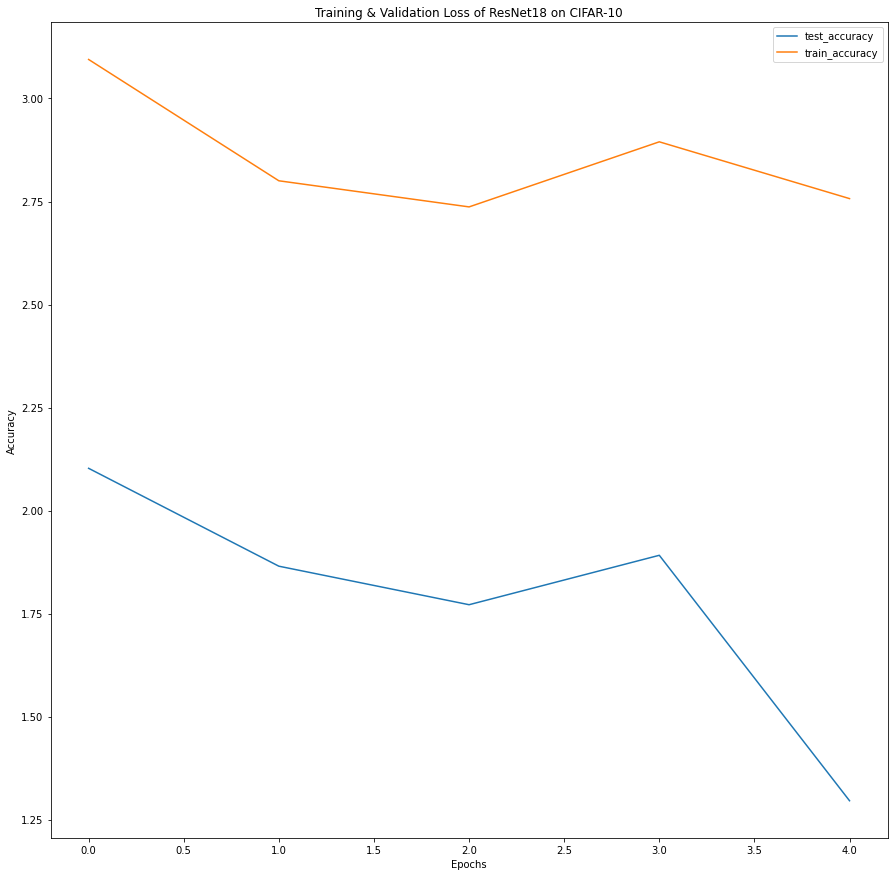

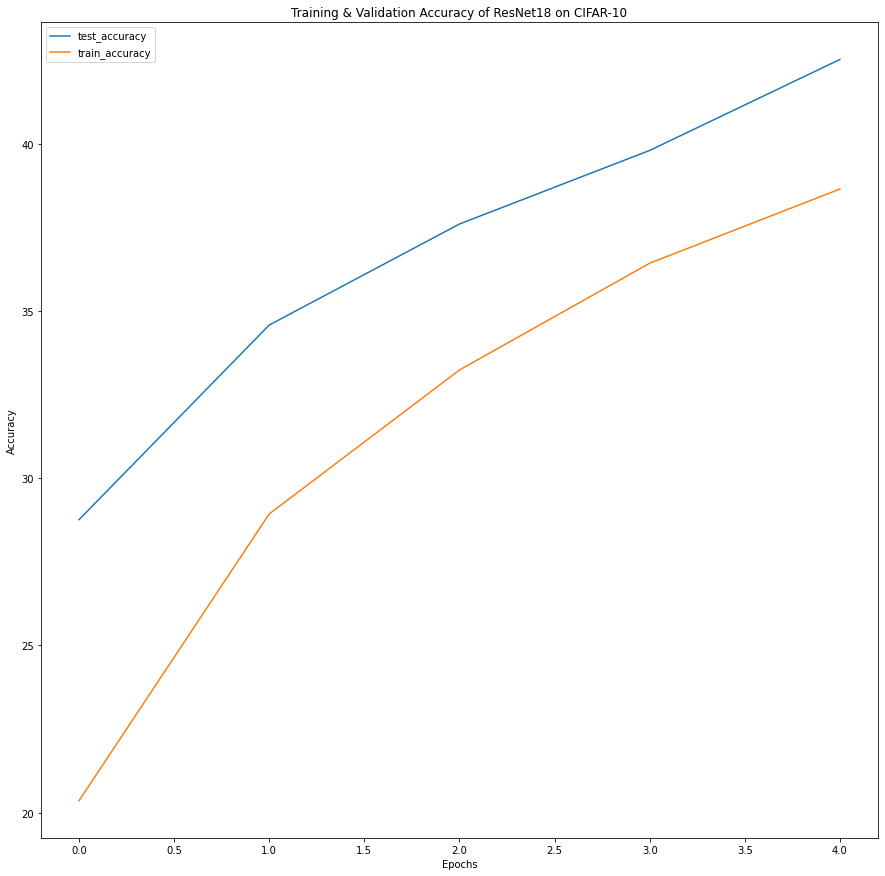

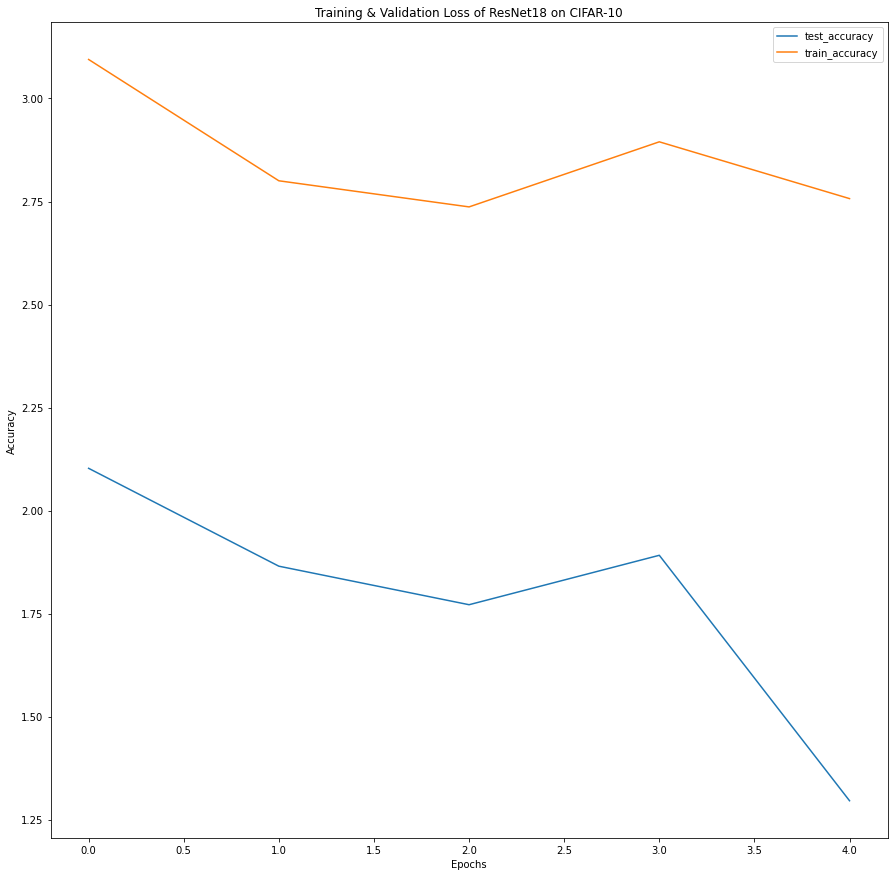

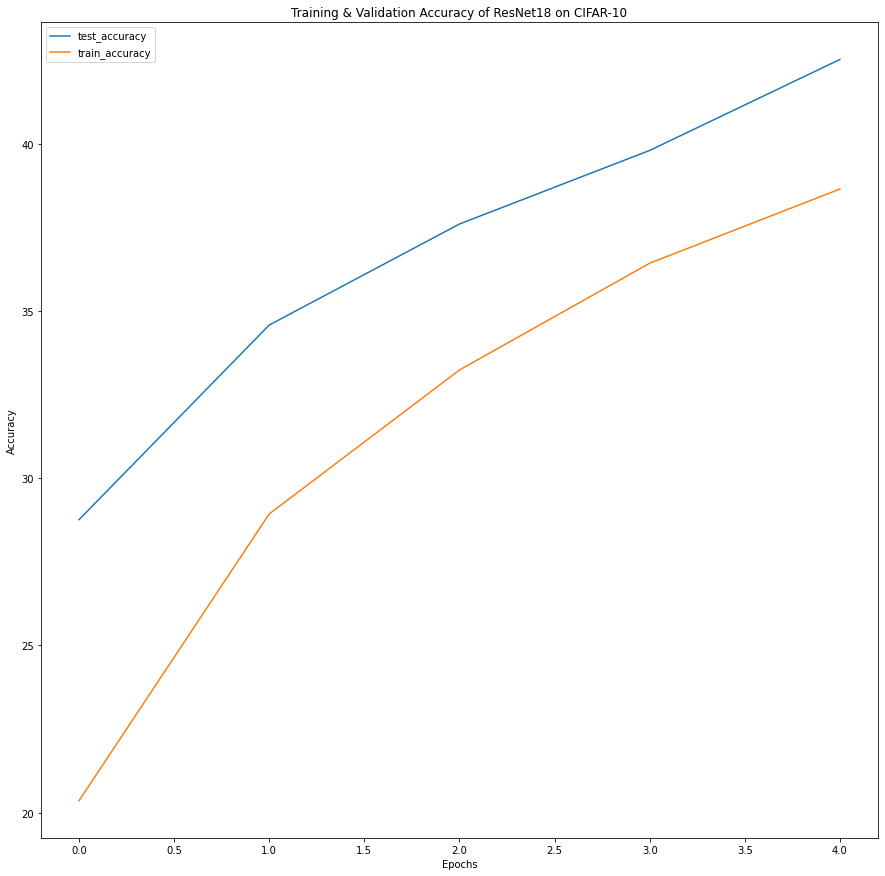

In [41]:
accuracyElements = [(model1.test_acc,"test_accuracy"),(model1.train_epoch_end,"train_accuracy")]
lossElements = [(model1.test_losses,"test_accuracy"),(model1.train_losses,"train_accuracy")]
for i in range(2):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Data for GradCam**

**GradCam Implementation**

In [38]:

images1 = [x['image'] for x in incorrectSamples[10:20]]
target_classes1 = [l['label'] for l in incorrectSamples[10:20]]
predicted_classes1= [p['prediction'] for p in incorrectSamples[10:20]]
# print(images)
print('***target-classes***')
tc1 = [classes[t] for t in target_classes]
print('***predicted-classes***')
pc1 = [classes[p] for p in predicted_classes]



***target-classes***
***predicted-classes***


['dog',
 'ship',
 'deer',
 'deer',
 'frog',
 'frog',
 'deer',
 'plane',
 'deer',
 'frog']

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


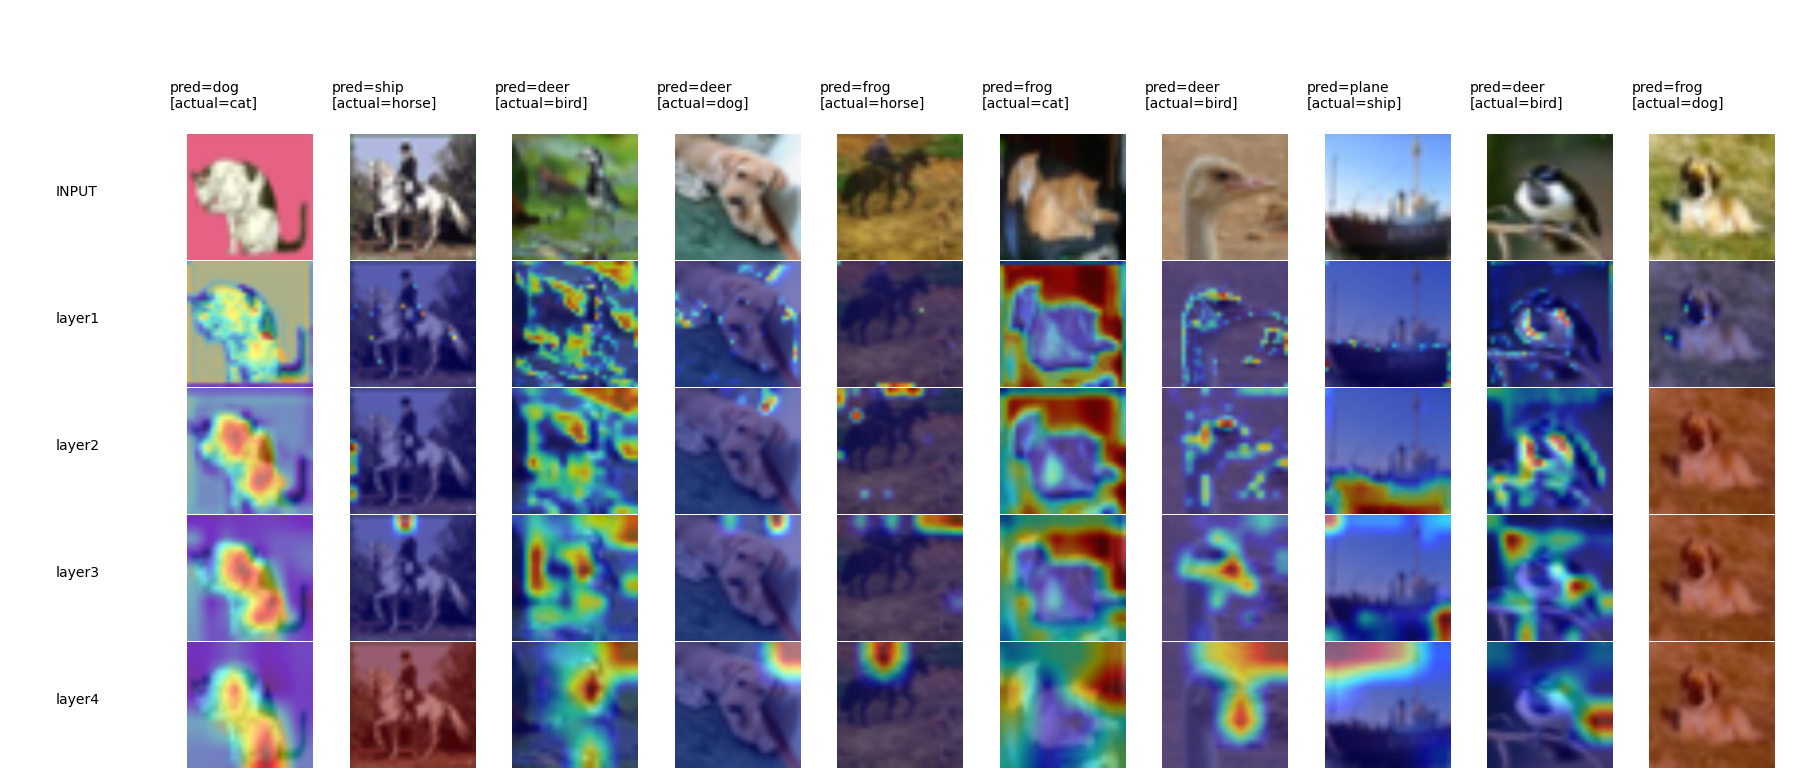

In [39]:

model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gc.GRADCAM(images, device, target_classes, model, target_layers) # target_classes required only in GRADCAM func

gc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, tc, pc)


<Figure size 936x936 with 0 Axes>

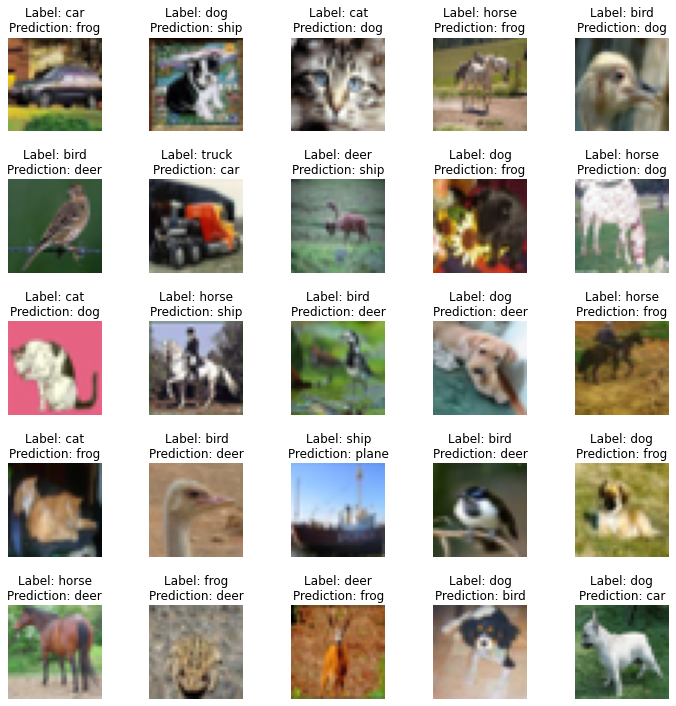

In [40]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')